Dataset Description

File descriptions

train.csv - the training set

test.csv - the test set

sampleSubmission.csv - a sample submission file in the correct format

Data fields

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [2]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import dill

from sklearn import ensemble
from matplotlib import style
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor


from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

style.use('fivethirtyeight')
%matplotlib inline

In [6]:
TEST_DATASET_PATH = '/content/test.csv'
TRAIN_DATASET_PATH = '/content/train.csv'

X_final = pd.read_csv(TEST_DATASET_PATH)
X = pd.read_csv(TRAIN_DATASET_PATH)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [8]:
X.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


Смотрим выбросы

Rooms

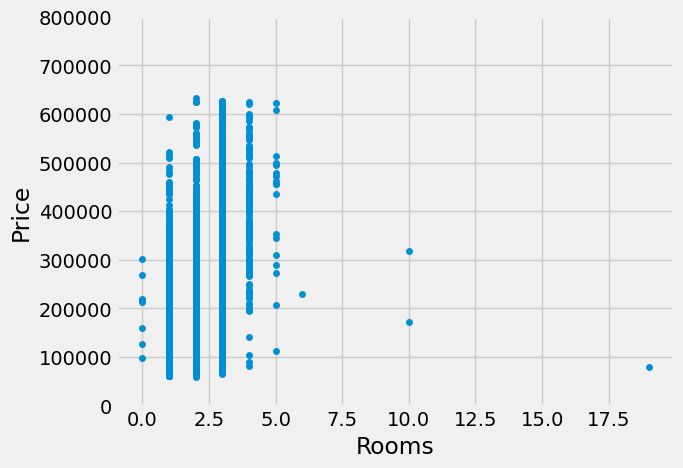

In [32]:
var = 'Rooms'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y='Price', ylim=(0,800000));

In [33]:
X['DistrictId']

0        35
1        41
2        53
3        58
4        99
       ... 
9995     32
9996     18
9997     27
9998     75
9999    128
Name: DistrictId, Length: 10000, dtype: int64

Square

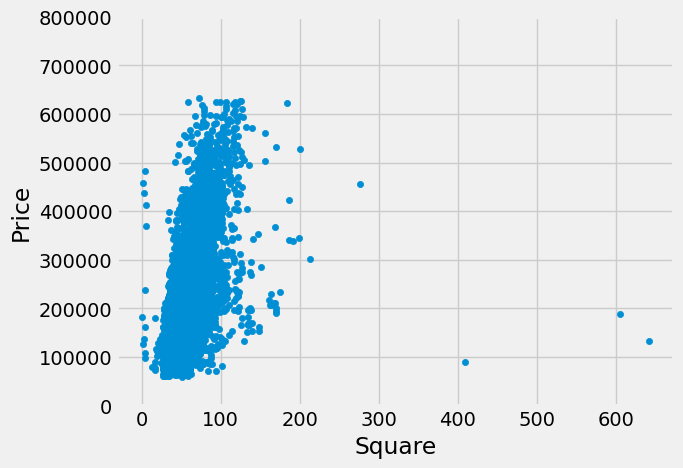

In [34]:
var = 'Square'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y='Price', ylim=(0,800000));

LifeSquare

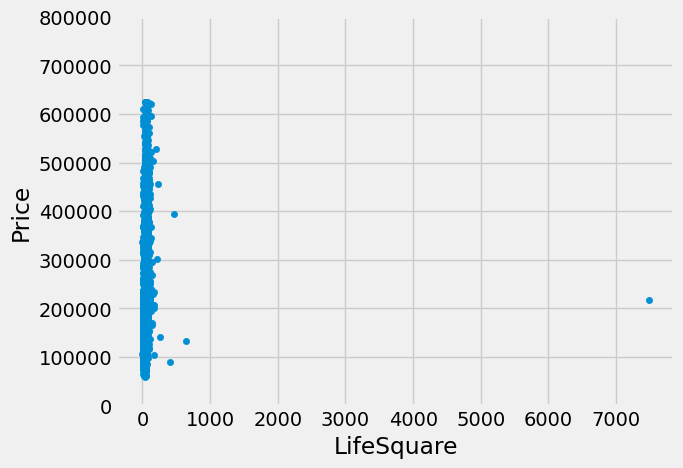

In [35]:
var = 'LifeSquare'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y='Price', ylim=(0,800000));

Floor, HouseFloor

In [36]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [37]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [38]:
(X['Floor'] > X['HouseFloor']).sum()

1825

HouseYear

In [39]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

Анализ признаков

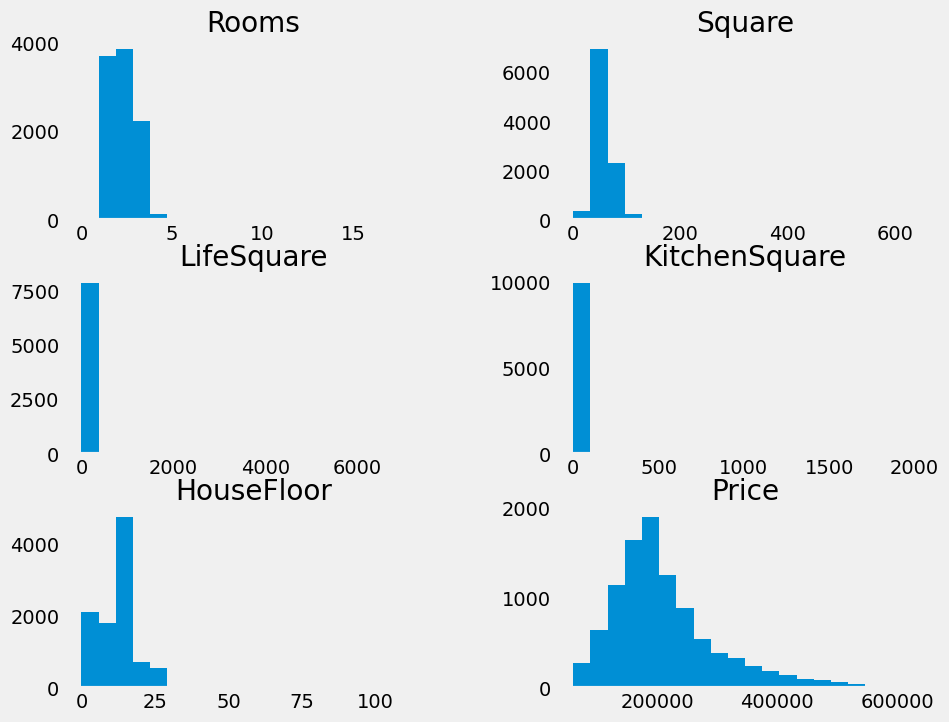

In [40]:
df_num_features = X.select_dtypes(include='float64')

# Удаляем малозначащие столбцы
num_features = pd.DataFrame(df_num_features)
num_features.drop("Ecology_1", axis=1, inplace=True)
num_features.drop("Healthcare_1", axis=1, inplace=True)
num_features.hist(figsize=(10, 8), bins=20, grid=False);

Корреляция признаков

<ipython-input-41-d8b8f070bfb6>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы


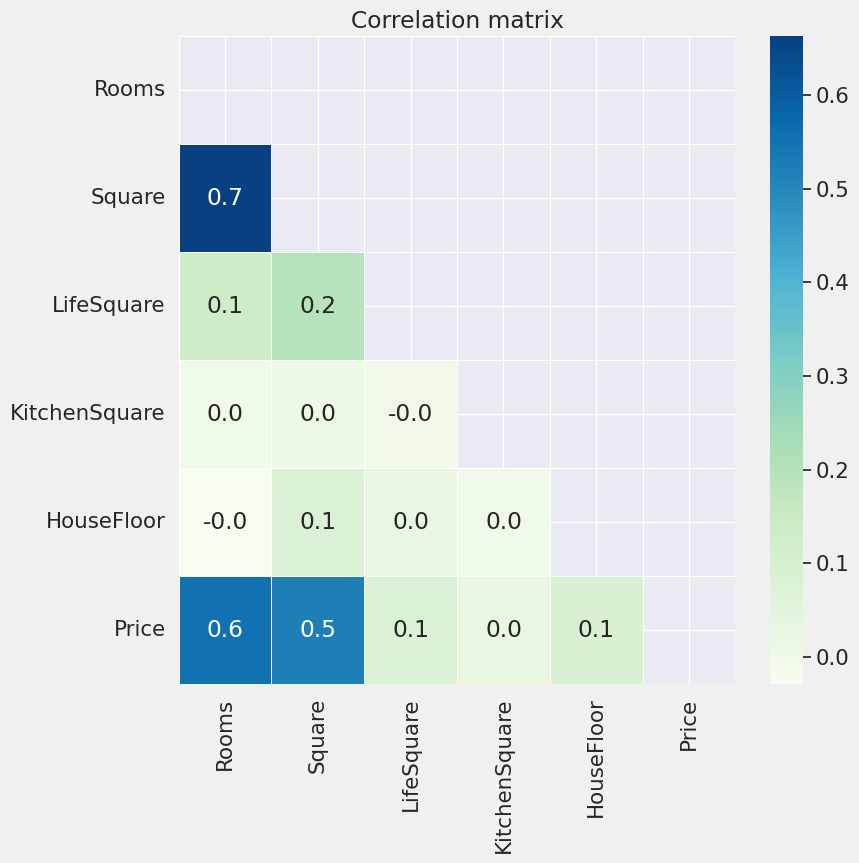

In [41]:
corr = num_features.corr()
plt.figure(figsize = (8, 8))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show();

In [42]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Очистка данных

In [43]:
X = X.sort_values('Price')
X_final = X_final.sort_values('DistrictId')

In [44]:
# Удаляем выбросы Rooms

X.sort_values(by = 'Rooms', ascending = False)[:3]
X = X.drop(X[X['Id'] == 8491].index)
X = X.drop(X[X['Id'] == 5927].index)
X = X.drop(X[X['Id'] == 14865].index)

In [45]:
# Удаляем выбросы Square
X.sort_values(by = 'Square', ascending = False)[:3]
X = X.drop(X[X['Id'] == 11602].index)
X = X.drop(X[X['Id'] == 28].index)
X = X.drop(X[X['Id'] == 2307].index)

In [46]:
# Удаляем выбросы HouseYear

X.sort_values(by = 'HouseYear', ascending = False)[:2]
X = X.drop(X[X['Id'] == 10814].index)
X = X.drop(X[X['Id'] == 11607].index)

In [47]:
# Удаляем выбросы LifeSquare

X.sort_values(by = 'LifeSquare', ascending = False)[:4]
X = X.drop(X[X['Id'] == 16550].index)
X = X.drop(X[X['Id'] == 15886].index)
X = X.drop(X[X['Id'] == 14990].index)
X = X.drop(X[X['Id'] == 5548].index)
X = X.drop(X[X['Id'] == 7917].index)
X = X.drop(X[X['Id'] == 16568].index)

Создаем класс для подчищения выбросов

In [48]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""

    def __init__(self):
        self.medians=None

    def fit(self, X):
        self.medians = X.median()

    def transform(self, X):

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1

        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        X.loc[(X['Rooms'] > 5) & (X['Square'] < 50),'Rooms'] = 2

        # Square
        X.loc[X['Square'] < 10,'Square']= X.loc[X['Square'] < 10,'Square']*10
        X.loc[X['Square'] < 1,'Square'] = X.loc[X['Square']<1,'Square']*100
        X.loc[X['Square'] > 250, 'Square'] = self.medians['Square']

        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = self.medians['KitchenSquare']

        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1

        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']

        # HouseYear
        current_year = now = datetime.datetime.now().year

        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1

        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = self.medians['HouseYear']

        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)

        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1

        X.loc[(X['LifeSquare'] > 200) &\
               (X['Square'] < 100),'LifeSquare']=X.loc[(X['LifeSquare']>200) & (X['Square']<100),'LifeSquare']/10

        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())

        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] * 0.65


        return X

In [49]:
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X)
X_final = imputer.transform(X_final)

<ipython-input-48-6f917a9d900a>:8: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  self.medians = X.median()


In [50]:
X = X.sort_values('Price')
X_final = X_final.sort_values('DistrictId')
X = X.fillna(method='pad')
X_final = X_final.fillna(method='pad')

In [51]:
y = X.Price
X.drop("Price", axis=1, inplace=True)
X.drop("Id", axis=1, inplace=True)

In [52]:
X = pd.get_dummies(X)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.33, random_state=42)
#save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

In [54]:
FEATURES = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear']

In [55]:
X_train = X_train[FEATURES]

Проверяем данные

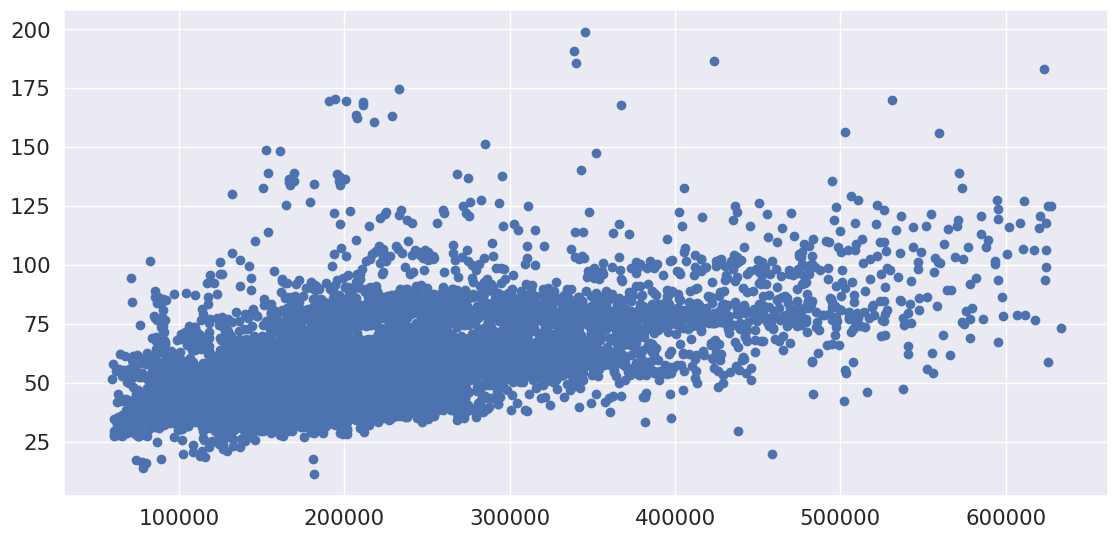

In [56]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

plt.scatter(y, X.Square)

Строим модель

In [62]:
%%time
model1 = LGBMRegressor(max_depth=6,
                             n_estimators=300,
                             random_state=42, num_leaves=10)

cv_score = cross_val_score(model1, X_train, y_train,
                           scoring='r2',
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 5352, number of used features: 8
[LightGBM] [Info] Start training from score 215002.871005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [63]:
%%time
model2 = RandomForestRegressor(n_estimators=300, max_depth=18, random_state=42, max_features=7)

cv_score = cross_val_score(model2, X_train, y_train,
                           scoring='r2',
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.668 +- 0.016
CPU times: user 37 s, sys: 62.8 ms, total: 37.1 s
Wall time: 38.7 s


In [64]:
model = VotingRegressor([('model1', model1), ('model2', model2), ])

In [65]:
%%time
cv_score = cross_val_score(model, X_train, y_train,
                           scoring='r2',
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 5352, number of used features: 8
[LightGBM] [Info] Start training from score 215002.871005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [66]:
model.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 6690, number of used features: 8
[LightGBM] [Info] Start training from score 214359.697908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


VotingRegressor(estimators=[('model1',
                             LGBMRegressor(max_depth=6, n_estimators=300,
                                           num_leaves=10, random_state=42)),
                            ('model2',
                             RandomForestRegressor(max_depth=18, max_features=7,
                                                   n_estimators=300,
                                                   random_state=42))])

In [67]:
with open("model.dill", "wb") as f:
    dill.dump(model, f)